In [4]:
!pip install matplotlib
!pip install colorama

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import colorama

matplotlib.rc('font', size=16)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
torch.__version__

'1.0.0'

In [3]:
resize_transformer = transforms.Resize(400)
affine_transformer = transforms.RandomAffine(degrees=10, scale=(0.8,1.2), shear=15)
random_resize_crop_transformer = transforms.RandomResizedCrop(299, scale=(0.5, 1))
tensor_transformer = transforms.ToTensor()

In [22]:
data_dir = os.path.join(os.getcwd(), "dataset302")

train_data = datasets.ImageFolder(os.path.join(data_dir, "train"),
                            transform = transforms.Compose([
                                resize_transformer,
                                affine_transformer,
                                random_resize_crop_transformer,
                                tensor_transformer
                            ]))

test_data = datasets.ImageFolder(os.path.join(data_dir, "val"),
                            transform = transforms.Compose([
                                transforms.Resize(350),
                                transforms.CenterCrop(299),
                                transforms.ToTensor()
                            ]))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, num_workers=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=16, shuffle=True)
class_names = train_data.classes

In [5]:
num_classes = len(class_names)
num_classes

302

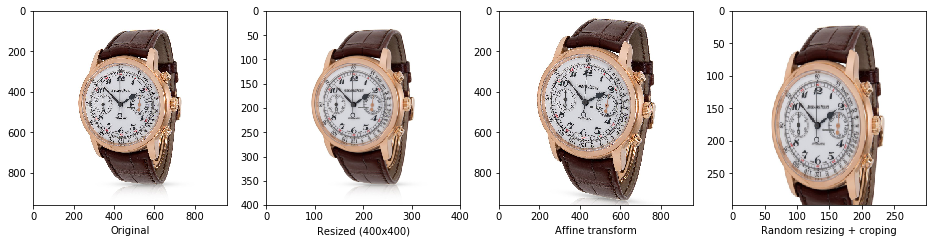

In [6]:
preview_data = datasets.ImageFolder(os.path.join(data_dir, "train"))
img, label = next(iter(preview_data))

fig = plt.figure(figsize=(16,9))
plt.subplot(1, 4, 1)
plt.xlabel('Original')
plt.imshow(tensor_transformer(img).permute(1, 2, 0))
plt.subplot(1, 4, 2)
plt.xlabel('Resized (400x400)')
plt.imshow(tensor_transformer(resize_transformer(img)).permute(1, 2, 0))
plt.subplot(1, 4, 3)
plt.xlabel('Affine transform')
plt.imshow(tensor_transformer(affine_transformer(img)).permute(1, 2, 0))
plt.subplot(1, 4, 4)
plt.xlabel('Random resizing + croping')
plt.imshow(tensor_transformer(random_resize_crop_transformer(img)).permute(1, 2, 0))

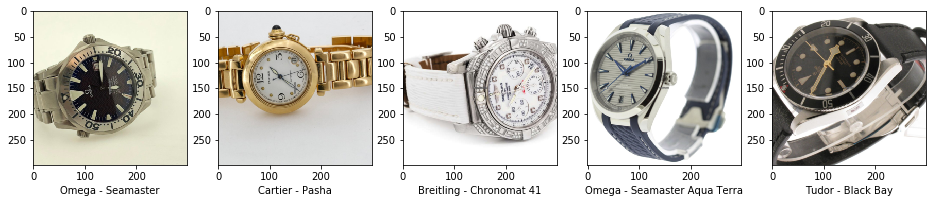

In [7]:
data, labels = next(iter(test_loader))
data, labels = data[:5], labels[:5]

fig = plt.figure(figsize=(16,9))
for i in range(0, 5):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(data[i].permute(1, 2, 0))
    plt.xlabel(class_names[labels[i]])

In [8]:
print(dir(models))

['AlexNet', 'DenseNet', 'Inception3', 'ResNet', 'SqueezeNet', 'VGG', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception', 'inception_v3', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [9]:
model_ft = models.inception_v3(pretrained=True)
model_ft

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [10]:
model_ft.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [11]:
model_ft.AuxLogits.fc

Linear(in_features=768, out_features=1000, bias=True)

In [12]:
model_ft.AuxLogits.fc = nn.Linear(in_features=768, out_features=num_classes)
model_ft.fc = nn.Linear(in_features=2048, out_features=num_classes)

In [13]:
model_ft.fc

Linear(in_features=2048, out_features=302, bias=True)

In [18]:
def train(model, train_loader, test_loader, device, num_epochs=1, lr=1e-5, use_scheduler=False, is_inception=False):
    model.train()  # not necessary in our example, but still good practice since modules
                   # like nn.Dropout, nn.BatchNorm require it
        
    # define an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, 0.85)
    
    for epoch in range(num_epochs):
        print("="*40, "Starting epoch %d" % (epoch + 1), "="*40)
        
        if use_scheduler:
            scheduler.step()
        
        cum_loss = 0
        # dataloader returns batches of images for 'data' and a tensor with their respective labels in 'labels'
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            
            if is_inception:
                outputs, aux_outputs = model(data)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2
            else:
                output = model(data)
                loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            cum_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print("Batch %d/%d" % (batch_idx, len(train_loader)))

        train_acc = accuracy(model, train_loader, device)
        test_acc = accuracy(model, test_loader, device)
        print(colorama.Fore.GREEN + "\nEpoch %d/%d, Loss=%.4f, Train-Acc=%d%%, Valid-Acc=%d%%" 
              % (epoch+1, num_epochs, cum_loss/len(train_data), 100*train_acc, 100*test_acc), colorama.Fore.RESET)

In [19]:
def accuracy(model, dataloader, device):
    """ Computes the model's accuracy on the data provided by 'dataloader'
    """
    model.eval()
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():  # deactivates autograd, reduces memory usage and speeds up computations
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            predictions = model(data).max(1)[1]  # indices of the maxima along the second dimension
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
        
    return num_correct / num_samples

In [16]:
for name, param in model_ft.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

In [ ]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

train(model_ft, train_loader, test_loader, device, num_epochs=1, is_inception=True)

======================================== Starting epoch 1 ========================================
Batch 0/2481
Batch 100/2481


In [50]:
data.shape

torch.Size([5, 3, 224, 224])

In [21]:
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.5 µs
